# Rana - the RA Eye Hospital Chatbot
**_First release_** 

developed by _Razan Aljuraysi_

## Importing Necessary Libraries and Downloads

In [1]:
import json
import string
import random 
import nltk
import csv
import time
import logging
import pandas as pd
import numpy as np
import tensorflow as tf 
from nltk.stem import WordNetLemmatizer 

from nltk.corpus import stopwords
from spellchecker import SpellChecker
import contractions

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

nltk.download("punkt")
nltk.download("wordnet")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\r-a-a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\r-a-a\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [2]:
# Create a new data structure to store the intents, patterns, and responses
intents_data = {}

# Read the CSV file
with open("merged_data.csv", "r") as csvfile:
    csvreader = csv.reader(csvfile)
    # Skip the header row
    next(csvreader)

    for row in csvreader:
        intent, pattern, response, requires_login = row
        if intent not in intents_data:
            intents_data[intent] = {
                "patterns": [],
                "responses": [],
                "requires_login": requires_login.lower() == "true"
            }

        intents_data[intent]["patterns"].append(pattern)
        intents_data[intent]["responses"].append(response)

# Convert the new data structure to the format used in the current code
new_data = {"intents": []}
for intent, values in intents_data.items():
    new_intent = {
        "tag": intent,
        "patterns": values["patterns"],
        "responses": values["responses"],
        "requires_login": values["requires_login"]
    }
    new_data["intents"].append(new_intent)

# Replace the old data variable with the new_data variable
data = new_data


In [3]:
# Preprocessing the data
lemmatizer = WordNetLemmatizer()
intents = data["intents"]

words = []
classes = []
doc_X = []
doc_y = []

for intent in intents:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(tokens)
        doc_y.append(intent["tag"])
        
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in string.punctuation]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

# Creating training data
training = []
output_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    bow = []
    text = [lemmatizer.lemmatize(word.lower()) for word in doc]
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    output_row = list(output_empty)
    output_row[classes.index(doc_y[idx])] = 1
    training.append([bow, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))


In [4]:
# Create a SpellChecker object
spell = SpellChecker()

# Get the list of stopwords from nltk
stopwords = stopwords.words('english')

In [5]:
def clean_text(text):
    tokens = nltk.word_tokenize(text)

    # Lemmatize the words
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]

    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    # Correct typos
    tokens = [spell.correction(word) for word in tokens]

    # Expand contractions
    tokens = [contractions.fix(word) for word in tokens]

    return tokens

def bag_of_words(text, vocab):
    tokens = clean_text(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    return np.array(bow)


## Model Building and Training

In [6]:
# Building the model
model = Sequential()
model.add(Dense(128, input_shape=(len(train_X[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

history = model.fit(train_X, train_y, epochs=200, batch_size=5, verbose=1)



Epoch 1/200
106/106 [==============================] - 1s 2ms/step - loss: 3.4629 - accuracy: 0.0494
Epoch 2/200
106/106 [==============================] - 0s 1ms/step - loss: 3.2426 - accuracy: 0.1103
Epoch 3/200
106/106 [==============================] - 0s 2ms/step - loss: 2.9736 - accuracy: 0.2015
Epoch 4/200
106/106 [==============================] - 0s 2ms/step - loss: 2.5673 - accuracy: 0.3213
Epoch 5/200
106/106 [==============================] - 0s 2ms/step - loss: 2.1438 - accuracy: 0.4449
Epoch 6/200
106/106 [==============================] - 0s 2ms/step - loss: 1.7365 - accuracy: 0.5266
Epoch 7/200
106/106 [==============================] - 0s 2ms/step - loss: 1.5123 - accuracy: 0.5932
Epoch 8/200
106/106 [==============================] - 0s 2ms/step - loss: 1.3497 - accuracy: 0.6141
Epoch 9/200
106/106 [==============================] - 0s 1ms/step - loss: 1.1380 - accuracy: 0.7091
Epoch 10/200
106/106 [==============================] - 0s 1ms/step - loss: 1.0289 - accura

106/106 [==============================] - 0s 1ms/step - loss: 0.0736 - accuracy: 0.9810
Epoch 82/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9772
Epoch 83/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9753
Epoch 84/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.9753
Epoch 85/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.9753
Epoch 86/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9867
Epoch 87/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.9810
Epoch 88/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9829
Epoch 89/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9848
Epoch 90/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0880 - accuracy: 

106/106 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.9829
Epoch 161/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.9905
Epoch 162/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9848
Epoch 163/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0606 - accuracy: 0.9772
Epoch 164/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9791
Epoch 165/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9810
Epoch 166/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9810
Epoch 167/200
106/106 [==============================] - 0s 1ms/step - loss: 0.0405 - accuracy: 0.9867
Epoch 168/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9772
Epoch 169/200
106/106 [==============================] - 0s 2ms/step - loss: 0.0651 - a

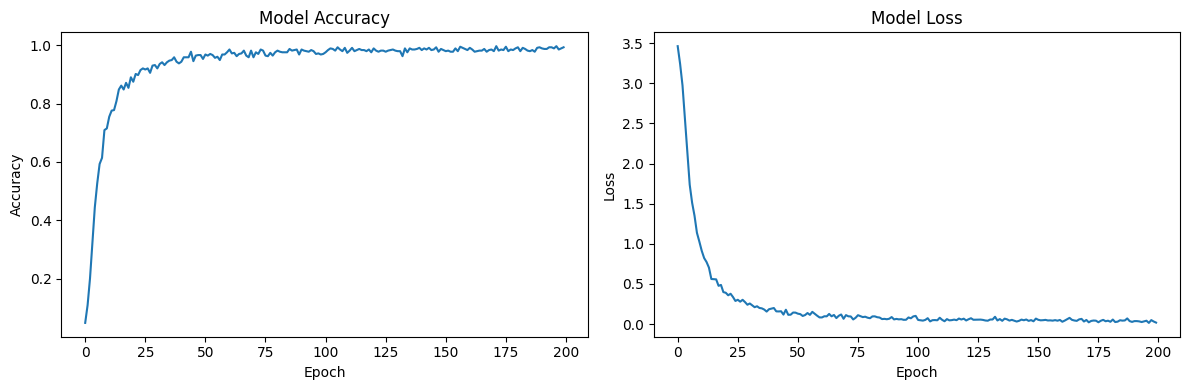

In [8]:
plot_history(history)

In [9]:

model.save("chatbot_model.h5")

with open("words.json", "w") as outfile:
    json.dump(words, outfile)

with open("classes.json", "w") as outfile:
    json.dump(classes, outfile)

## Task-Oriented Functions

In [10]:
# Task-oriented functions

def book_appointment():
    # Placeholder code
    print("Just testing if this works - booking appointment.")
    return "Your appointment booking is being processed."

def cancel_appointment():
    # Placeholder code
    print("Just testing if this works - cancelling appointment.")
    return "Your appointment cancellation is being processed."

def reschedule_appointment():
    # Placeholder code
    print("Just testing if this works - rescheduling appointment.")
    return "Your appointment rescheduling is being processed."

def view_upcoming_appointments():
    # Placeholder code
    print("Just testing if this works - viewing upcoming appointments.")
    return "Loading your upcoming appointments."

def view_appointment_history():
    # Placeholder code
    print("Just testing if this works - viewing appointment history.")
    return "Loading your appointment history."

def medication_refill():
    # Placeholder code
    print("Just testing if this works - refilling medication.")
    return "Your medication refill is being processed."

def current_medication():
    # Placeholder code
    print("Just testing if this works - viewing current medication.")
    return "Loading your current medication."

def medication_dose():
    # Placeholder code
    print("Just testing if this works - viewing medication dose.")
    return "Loading your medication dose."

def medication_start_end():
    # Placeholder code
    print("Just testing if this works - viewing medication start and end dates.")
    return "Loading your medication start and end dates."

def medication_refill_date():
    # Placeholder code
    print("Just testing if this works - viewing medication refill date.")
    return "Loading your medication refill date."


## Text Processing and Prediction Functions

In [11]:

def predict_class(text, model):
    bow = bag_of_words(text, words)
    res = model.predict(np.array([bow]), verbose= 3)[0]
    thresh = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > thresh]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]["intent"]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            # Add a confirmation step before performing the action
            print(f"You want to {tag.replace('_', ' ')}, is that right? (yes/no)")
            confirmation = input().lower()
            if confirmation == 'yes':
                if tag == "book_appointment":
                    result = book_appointment()
                elif tag == "cancel_appointment":
                    result = cancel_appointment()
                elif tag == "reschedule_appointment":
                    result = reschedule_appointment()
                elif tag == "view_upcoming_appointments":
                    result = view_upcoming_appointments()
                elif tag == "view_appointment_history":
                    result = view_appointment_history()
                elif tag == "medication_refill":
                    result = medication_refill()
                elif tag == "current_medication":
                    result = current_medication()
                elif tag == "medication_dose":
                    result = medication_dose()
                elif tag == "medication_start_end":
                    result = medication_start_end()
                elif tag == "medication_refill_date":
                    result = medication_refill_date()
                else:
                    result = random.choice(i["responses"])
            else:
                result = "Okay, how else can I assist you?"
            break
    return result



## User Validation Function

In [12]:
# Function to validate user's credentials
def validate_credentials(national_id, last_name, phone_number):
    patients_data = pd.read_csv('databases/general_databases/patients_data.csv', 
                                dtype={'phone_number': str, 'national_ID': str})
    # Remove hyphens from phone numbers in the CSV file
    patients_data['phone_number'] = patients_data['phone_number'].str.replace('-', '')

    # Remove hyphens from the input phone number
    phone_number = phone_number.replace('-', '')

    matching_patient = patients_data[
        (patients_data['national_ID'] == national_id) &
        (patients_data['last_name'].str.lower() == last_name.lower()) &
        (patients_data['phone_number'] == phone_number)
    ]

    if matching_patient.empty:
        return False, None
    else:
        return True, matching_patient['File_number'].values[0]



## Chatbot Conversation and Exception Handling

In [13]:
patients_data = pd.read_csv('databases/general_databases/patients_data.csv', dtype={'phone_number': str})
patients_data

,File_number,phone_number,national_ID,first_name,middle_name,last_name
0,10001,5551234567,123456789,Reyam,A,Alotaibi
1,10002,5552345678,234567890,Amal,B,Almari
2,10003,5553456789,345678901,Khalid,C,Alsalem


In [14]:
logging.basicConfig(filename="chatbot_errors.log", level=logging.ERROR)

# Login procedure before the chatbot conversation begins
print("Hello and welcome to Razan Aljuraysi Eye Hospital. My name is Rana, before I can help you with anything, I need to confirm your details")

for _ in range(3):
    national_id = input("Please provide your national ID and press enter: ")
    last_name = input("Please provide your last name: ")
    phone_number = input("Please provide your phone number: ")

    is_valid, file_number = validate_credentials(national_id, last_name, phone_number)

    if is_valid:
        print("Thank you for providing your details. How can I assist you today?")
        # Continue with the chatbot conversation
        break
    else:
        print("I'm afraid your details doesn't match our data, please make sure you're using the correct details then try again.")

if not is_valid:
    print("Your details still doesn't match our data, you may not be registered at our hospital. If you think there is something wrong, please contact our IT team at 0555555553.")
    
    
print("Hello and welcome to Razan Aljuraysi Eye Hospital. My name is Rana, how can I assist you today?")

timeout = 30
start_time = time.time()

while True:
    try:
        input_text = input("You: ")
        if input_text.lower() == "quit":
            break

        if time.time() - start_time > timeout:
            print("Chatbot: I'm sorry, but I didn't receive a response. Can I assist you with something else?")
            start_time = time.time()
            continue
        
        if input_text.lower() == "value_error":  # Simulate a ValueError
            raise ValueError("Test ValueError")

        if input_text.lower() == "index_error":  # Simulate an IndexError
            raise IndexError("Test IndexError")

        start_time = time.time()
        intents_list = predict_class(input_text, model)
        response = get_response(intents_list, data)
        print("Chatbot: ", response)
        

    except KeyboardInterrupt:
        print("\nExiting the chat. Goodbye!")
        break
    except ValueError as ve:
        print("Chatbot: I'm sorry, I didn't understand your input. could you rephrase.")
        logging.error(f"ValueError: {ve}")

    except IndexError as ie:
        print("Chatbot: I'm sorry, I didn't understand your input. Please rephrase.")
        logging.error(f"IndexError: {ie}")

    except Exception as e:
        print("Chatbot: I'm sorry, I didn't get it. Please try again.")
        logging.error(f"Unexpected error: {e}")

        #break

Hello and welcome to Razan Aljuraysi Eye Hospital. My name is Rana, before I can help you with anything, I need to confirm your details


KeyboardInterrupt: Interrupted by user